In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import json
import sklearn
import math

In [2]:
results_df_raw = pd.read_parquet("Data/results_first_move_evaluated_full.parquet", engine='fastparquet')
results_df_raw.head()

,PuzzleId,FEN,Moves,Rating,RatingDeviation,Popularity,NbPlays,Themes,GameUrl,OpeningTags,...,transformer_moves_correct_top5,total_puzzle_moves,cnn_puzzle_pct,cnn_puzzle_pct_top3,cnn_puzzle_pct_top5,transformer_puzzle_pct,transformer_puzzle_pct_top3,transformer_puzzle_pct_top5,cnn_puzzle_complete,transformer_puzzle_complete
0,00008,r6k/pp2r2p/4Rp1Q/3p4/8/1N1P2R1/PqP2bPP/7K b - ...,f2g3 e6e7 b2b1 b3c1 b1c1 h6c1,1877,76,95,8786,crushing hangingPiece long middlegame,https://lichess.org/787zsVup/black#48,None,...,3,3,100.0,100.0,100.0,100.0,100.0,100.0,1,1
1,0000D,5rk1/1p3ppp/pq3b2/8/8/1P1Q1N2/P4PPP/3R2K1 w - ...,d3d6 f8d8 d6d8 f6d8,1501,73,96,35000,advantage endgame short,https://lichess.org/F8M8OS71#53,None,...,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,0008Q,8/4R3/1p2P3/p4r2/P6p/1P3Pk1/4K3/8 w - - 1 64,e7f7 f5e5 e2f1 e5e6,1355,76,91,743,advantage endgame rookEndgame short,https://lichess.org/MQSyb3KW#127,None,...,2,2,100.0,100.0,100.0,100.0,100.0,100.0,1,1
3,0009B,r2qr1k1/b1p2ppp/pp4n1/P1P1p3/4P1n1/B2P2Pb/3NBP...,b6c5 e2g4 h3g4 d1g4,1103,74,88,603,advantage middlegame short,https://lichess.org/4MWQCxQ6/black#32,Kings_Pawn_Game Kings_Pawn_Game_Leonardis_Vari...,...,2,2,100.0,100.0,100.0,100.0,100.0,100.0,1,1
4,000Pw,6k1/5p1p/4p3/4q3/3nN3/2Q3P1/PP3P1P/6K1 w - - 2 37,e4d2 d4e2 g1f1 e2c3,1422,74,92,604,crushing endgame fork short,https://lichess.org/au2lCK5o#73,None,...,2,2,0.0,0.0,100.0,0.0,100.0,100.0,0,0



Puzzles 100% Solved: CNN 53.70% | Transformer 59.99%


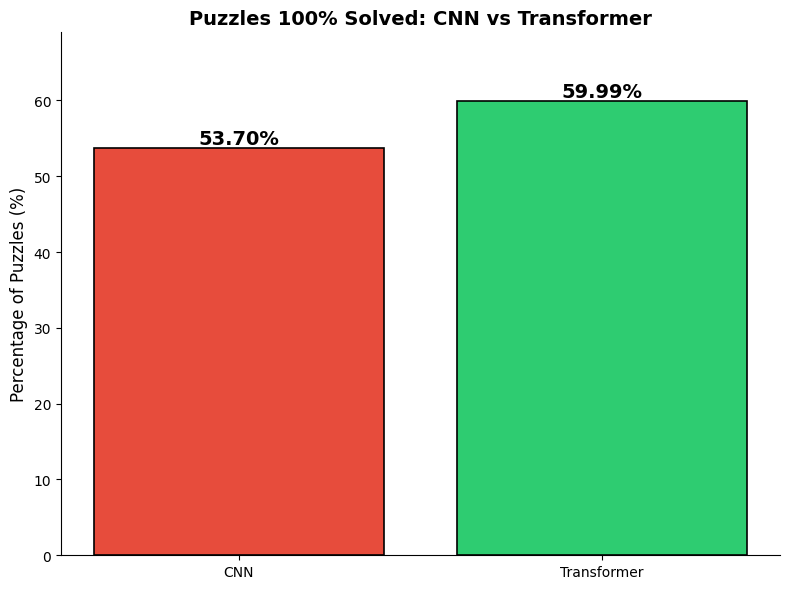

In [3]:
# Percentage of puzzles that were 100% solved (all moves correct)
cnn_fully_solved = results_df_raw['cnn_puzzle_complete'].mean() * 100
transformer_fully_solved = results_df_raw['transformer_puzzle_complete'].mean() * 100
print(f"\nPuzzles 100% Solved: CNN {cnn_fully_solved:.2f}% | Transformer {transformer_fully_solved:.2f}%")

# Create comparison bar plot showing aggregate accuracies
fig, ax = plt.subplots(figsize=(8, 6))

models = ['CNN', 'Transformer']
accuracies = [cnn_fully_solved, transformer_fully_solved]
colors = ['#e74c3c','#2ecc71']

bars = ax.bar(models, accuracies, color=colors, edgecolor='black', linewidth=1.2)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
            f'{acc:.2f}%', ha='center', va='bottom', fontsize=14, fontweight='bold')

# Formatting
ax.set_ylabel('Percentage of Puzzles (%)', fontsize=12)
ax.set_title('Puzzles 100% Solved: CNN vs Transformer', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(accuracies) * 1.15)  # Add space for labels
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


In [4]:
# Check in results dataset
missing = False
for col in results_df_raw.columns:
    missing_values = results_df_raw[col].isnull().sum()
    if missing_values > 0:
        print(f"Column '{col}' has {missing_values} missing values.")
        missing = True

if missing:
    print("Missing values found in the results dataset.")
else:
    print("No missing values found in the results dataset.")

# Check for duplicate PuzzleId values
dup_mask = results_df_raw['PuzzleId'].duplicated(keep=False) 
n_dup_rows = dup_mask.sum()
n_dup_ids = results_df_raw.loc[dup_mask, 'PuzzleId'].nunique()

if n_dup_ids == 0:
    print("No duplicate PuzzleId values found.")
else:
    print(f"Rows with duplicated PuzzleId: {n_dup_rows:,}")
    print(f"Unique PuzzleId values that are duplicated: {n_dup_ids:,}")

Column 'OpeningTags' has 4471771 missing values.
Missing values found in the results dataset.
No duplicate PuzzleId values found.


Summary statistics for numeric columns:


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
Rating,5600086.0,1483.663988,546.514349,399.0,462.0,663.0,1054.0,1435.0,1890.0,2438.0,2727.0,3395.0
RatingDeviation,5600086.0,87.110992,27.581030,45.0,74.0,74.0,76.0,78.0,88.0,119.0,209.0,500.0
Popularity,5600086.0,86.152684,14.267439,-83.0,25.0,58.0,83.0,90.0,94.0,100.0,100.0,100.0
NbPlays,5600086.0,1650.867153,4485.639812,0.0,8.0,24.0,107.0,350.0,1221.0,8222.0,21030.0,312554.0
total_puzzle_moves,5600086.0,2.322185,0.925840,1.0,1.0,1.0,2.0,2.0,3.0,4.0,5.0,17.0


--- Visualizing Puzzles Dataset ---


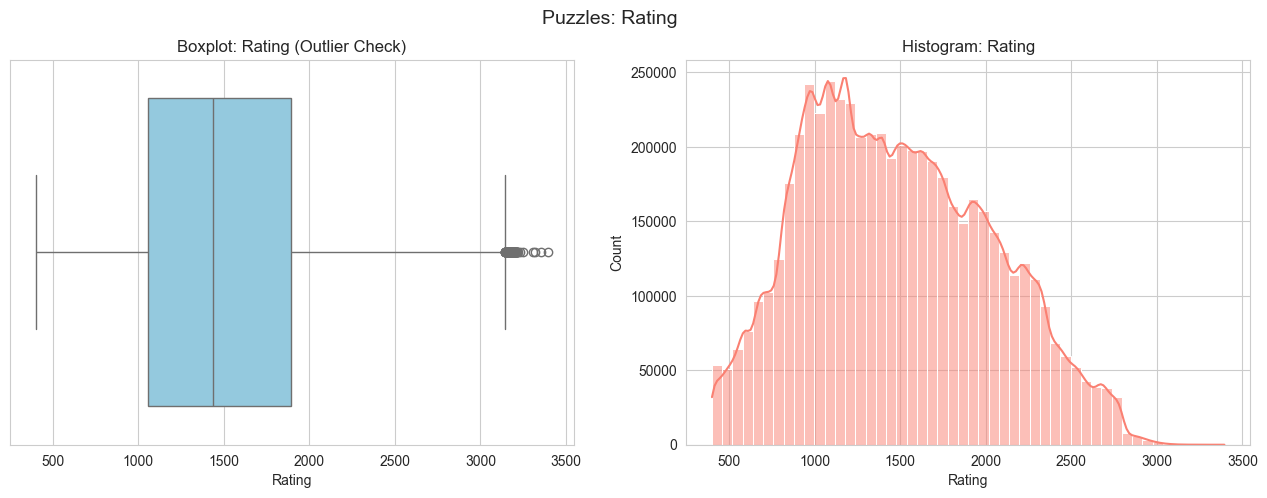

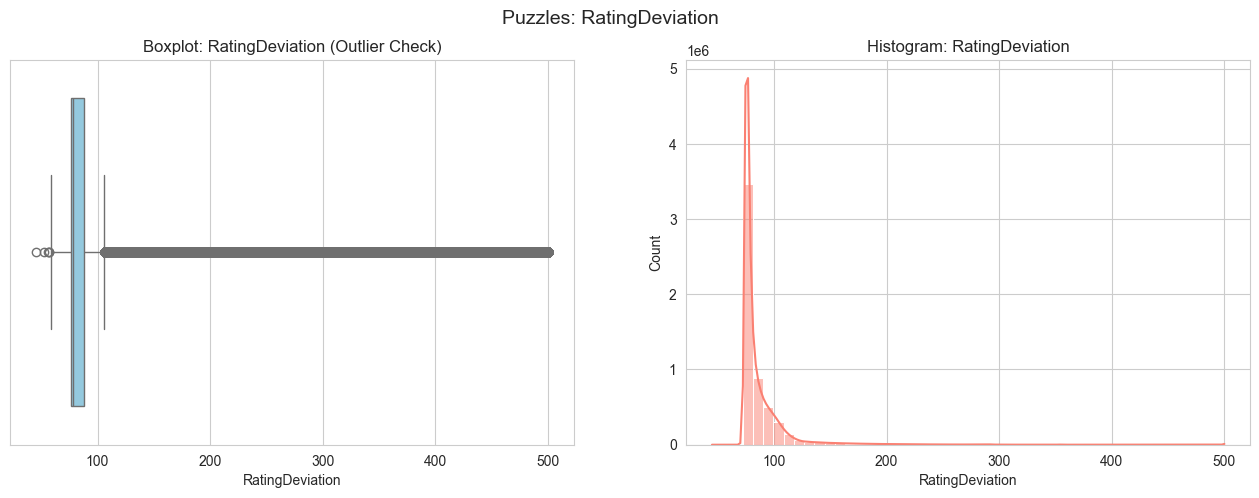

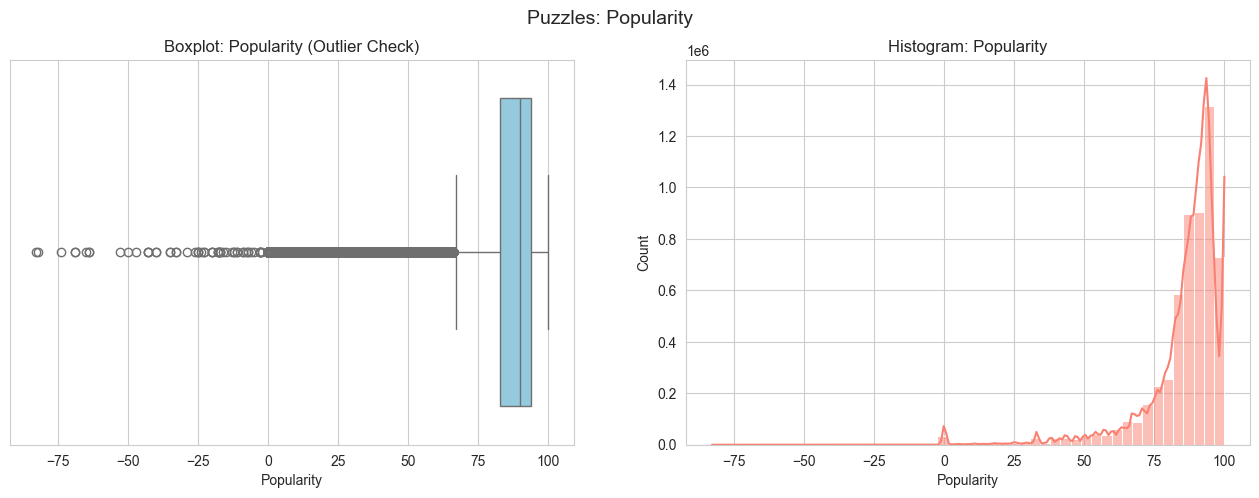

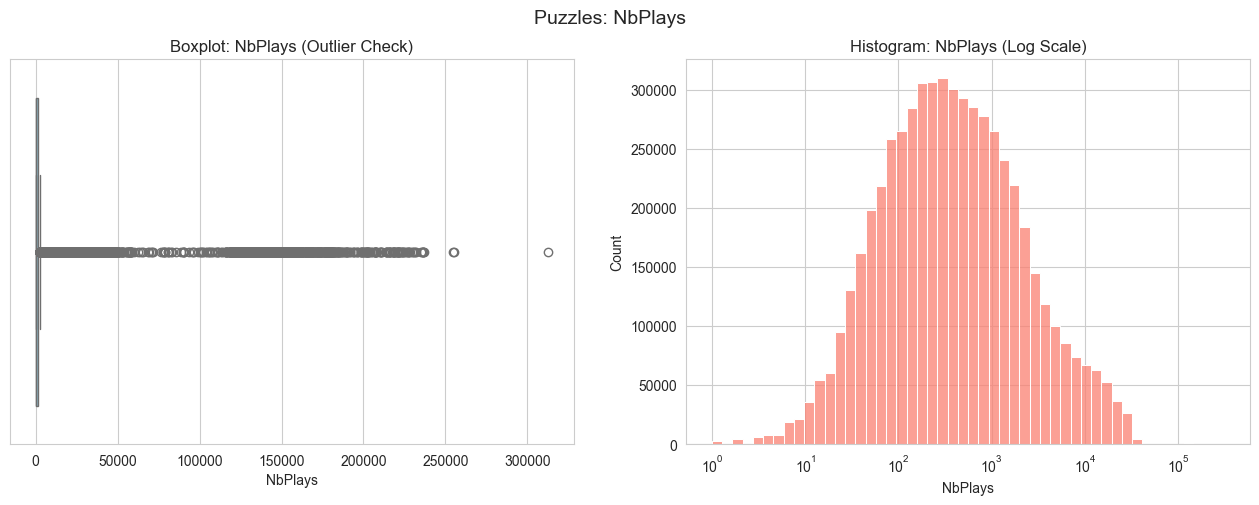

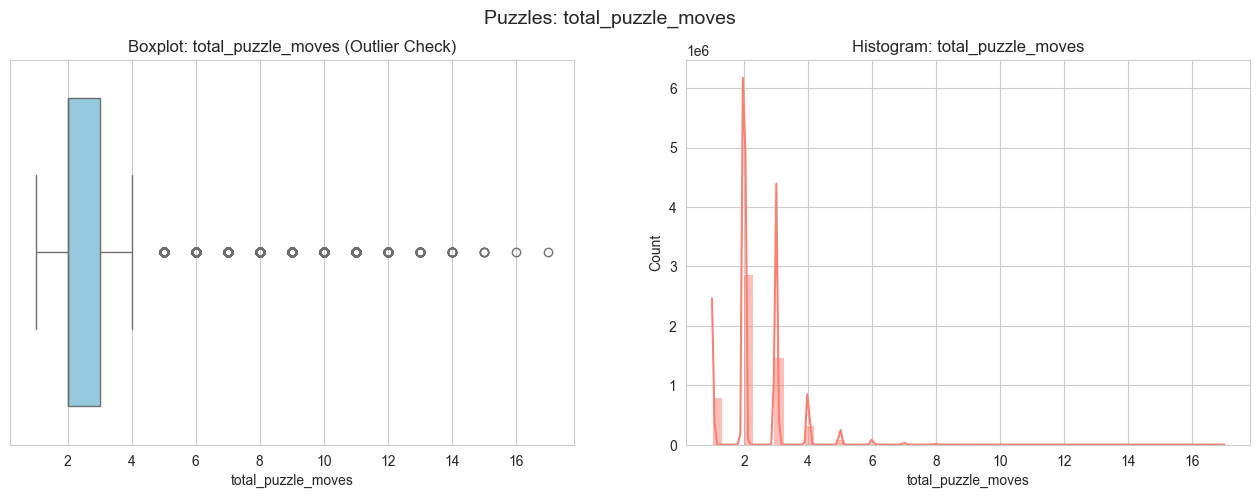

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cols = ['Rating', 'RatingDeviation', 'Popularity', 'NbPlays', 'total_puzzle_moves']

# --- 1) Basic sanity checks ---
print("Summary statistics for numeric columns:")
display(results_df_raw[cols].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T)

def visualize_outliers(df, columns, dataset_name):
    """
    Plots a Boxplot (left) and Histogram (right) for each column.
    """
    sns.set_style("whitegrid")
    
    for col in columns:
        fig, axes = plt.subplots(1, 2, figsize=(16, 5))
        
        # --- Plot 1: Boxplot (Horizontal) ---
        sns.boxplot(x=df[col], ax=axes[0], color='skyblue')
        axes[0].set_title(f'Boxplot: {col} (Outlier Check)')
        
        # --- Plot 2: Histogram ---
        # We use a log scale for the histogram if the data is massive (like NbPlays)
        # This allows you to actually SEE the distribution instead of just one bar.
        if df[col].max() > 10000 and df[col].min() >= 0:
            sns.histplot(df[col], ax=axes[1], color='salmon', bins=50, log_scale=True)
            axes[1].set_title(f'Histogram: {col} (Log Scale)')
        else:
            sns.histplot(df[col], ax=axes[1], color='salmon', bins=50, kde=True)
            axes[1].set_title(f'Histogram: {col}')
            
        plt.suptitle(f'{dataset_name}: {col}', fontsize=14)
        plt.show()

# --- EXECUTE VISUALIZATION ---

# 1. Visualize Puzzles
print("--- Visualizing Puzzles Dataset ---")
visualize_outliers(results_df_raw, ['Rating', 'RatingDeviation', 'Popularity', 'NbPlays', 'total_puzzle_moves'], "Puzzles")


In [6]:
from statsmodels.stats.contingency_tables import mcnemar

def perform_mcnemar_test(df, cnn_col, transformer_col, test_name):
    """
    Perform McNemar's test to compare CNN vs Transformer on paired binary outcomes.
    
    Contingency table:
                    Transformer Correct | Transformer Wrong
    CNN Correct     |       a           |        b
    CNN Wrong       |       c           |        d
    """
    # Remove rows with missing values
    df_clean = df[[cnn_col, transformer_col]].dropna()
    
    # Create contingency table
    both_correct = ((df_clean[cnn_col] == 1) & (df_clean[transformer_col] == 1)).sum()
    cnn_only = ((df_clean[cnn_col] == 1) & (df_clean[transformer_col] == 0)).sum()
    transformer_only = ((df_clean[cnn_col] == 0) & (df_clean[transformer_col] == 1)).sum()
    both_wrong = ((df_clean[cnn_col] == 0) & (df_clean[transformer_col] == 0)).sum()
    
    # Build 2x2 table
    table = [[both_correct, cnn_only],
             [transformer_only, both_wrong]]
    
    print(f"\n{'='*60}")
    print(f"McNemar's Test: {test_name}")
    print(f"{'='*60}")
    print(f"Sample size: {len(df_clean):,}")
    print(f"\nContingency Table:")
    print(f"                    Transformer Correct | Transformer Wrong")
    print(f"CNN Correct     |    {both_correct:>10,}      |   {cnn_only:>10,}")
    print(f"CNN Wrong       |    {transformer_only:>10,}      |   {both_wrong:>10,}")
    
    # Perform McNemar's test
    result = mcnemar(table, exact=False, correction=True)
    
    print(f"\nTest Statistic (χ²): {result.statistic:.4f}")
    print(f"P-value: {result.pvalue}")
    
    if result.pvalue < 0.001:
        print("Result: *** Highly significant difference (p < 0.001)")
    elif result.pvalue < 0.01:
        print("Result: ** Significant difference (p < 0.01)")
    elif result.pvalue < 0.05:
        print("Result: * Significant difference (p < 0.05)")
    else:
        print("Result: No significant difference (p ≥ 0.05)")
    
    # Interpretation
    if transformer_only > cnn_only:
        print(f"Interpretation: Transformer outperforms CNN ({transformer_only:,} vs {cnn_only:,})")
    elif cnn_only > transformer_only:
        print(f"Interpretation: CNN outperforms Transformer ({cnn_only:,} vs {transformer_only:,})")
    else:
        print("Interpretation: Models perform equally")
    
    return result

# Perform tests on different metrics
perform_mcnemar_test(results_df_raw, 'cnn_first_move_correct', 'transformer_first_move_correct', 
                     'First Move (Exact)')

perform_mcnemar_test(results_df_raw, 'cnn_puzzle_complete', 'transformer_puzzle_complete', 
                     'Full Puzzle Complete')


McNemar's Test: First Move (Exact)
Sample size: 5,600,086

Contingency Table:
                    Transformer Correct | Transformer Wrong
CNN Correct     |     3,340,975      |      343,791
CNN Wrong       |       630,159      |    1,285,161

Test Statistic (χ²): 84199.4545
P-value: 0.0
Result: *** Highly significant difference (p < 0.001)
Interpretation: Transformer outperforms CNN (630,159 vs 343,791)

McNemar's Test: Full Puzzle Complete
Sample size: 5,600,086

Contingency Table:
                    Transformer Correct | Transformer Wrong
CNN Correct     |     2,644,687      |      362,347
CNN Wrong       |       714,691      |    1,878,361

Test Statistic (χ²): 115265.7470
P-value: 0.0
Result: *** Highly significant difference (p < 0.001)
Interpretation: Transformer outperforms CNN (714,691 vs 362,347)


<bunch containing results, print to see contents>

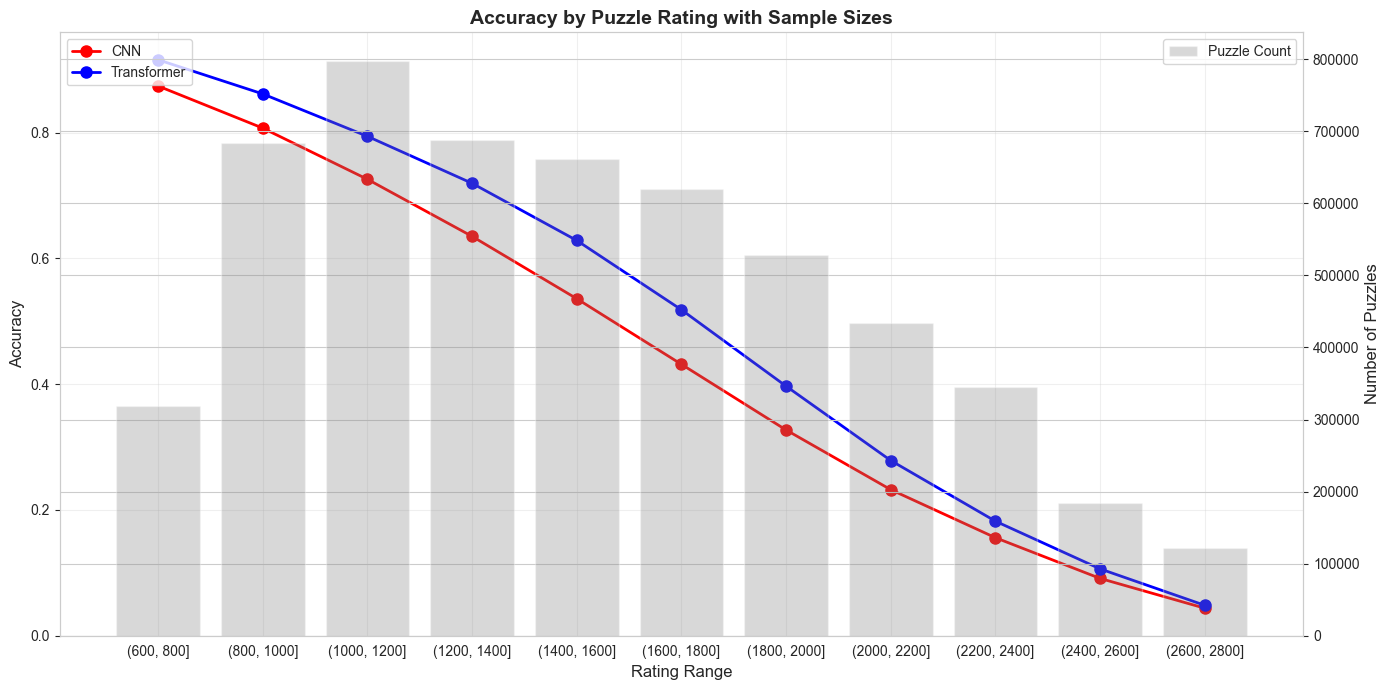


Accuracy and Puzzle Counts by Rating:


,rating_bin,cnn_puzzle_complete,transformer_puzzle_complete,puzzle_count,Gap (Trans - CNN)
0,"(600, 800]",0.874366,0.916127,319317,0.041761
1,"(800, 1000]",0.807404,0.861797,683197,0.054393
2,"(1000, 1200]",0.726000,0.794331,797620,0.068331
3,"(1200, 1400]",0.635192,0.719580,688075,0.084388
4,"(1400, 1600]",0.535983,0.628645,661017,0.092662
5,"(1600, 1800]",0.431605,0.518368,619515,0.086763
6,"(1800, 2000]",0.327127,0.396824,528706,0.069697
7,"(2000, 2200]",0.232171,0.278527,434400,0.046356
8,"(2200, 2400]",0.155727,0.182002,345502,0.026275
9,"(2400, 2600]",0.090954,0.106130,184246,0.015175


In [7]:
# Create Rating Bins (e.g., 600-800, 800-1000...)
results_df_raw['rating_bin'] = pd.cut(results_df_raw['Rating'], bins=range(600, 3000, 200))

# Calculate Accuracy per Bin and count puzzles
bin_analysis = results_df_raw.groupby('rating_bin', observed=True).agg({
    'cnn_puzzle_complete': 'mean',
    'transformer_puzzle_complete': 'mean',
    'PuzzleId': 'count'  # Count puzzles per bin
}).reset_index()
bin_analysis.rename(columns={'PuzzleId': 'puzzle_count'}, inplace=True)

# Calculate the Gap
bin_analysis['Gap (Trans - CNN)'] = bin_analysis['transformer_puzzle_complete'] - bin_analysis['cnn_puzzle_complete']

# Visualization with dual y-axis
fig, ax1 = plt.subplots(figsize=(14, 7))

# Primary axis: Accuracy lines
ax1.plot(bin_analysis['rating_bin'].astype(str), bin_analysis['cnn_puzzle_complete'], 
         marker='o', label='CNN', color='red', linewidth=2, markersize=8)
ax1.plot(bin_analysis['rating_bin'].astype(str), bin_analysis['transformer_puzzle_complete'], 
         marker='o', label='Transformer', color='blue', linewidth=2, markersize=8)

ax1.set_xlabel('Rating Range', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Secondary axis: Puzzle counts
ax2 = ax1.twinx()
ax2.bar(bin_analysis['rating_bin'].astype(str), bin_analysis['puzzle_count'], 
        alpha=0.3, color='gray', label='Puzzle Count')
ax2.set_ylabel('Number of Puzzles', fontsize=12)
ax2.tick_params(axis='y')
ax2.legend(loc='upper right')

plt.title('Accuracy by Puzzle Rating with Sample Sizes', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print the table to find the smallest gap
print("\nAccuracy and Puzzle Counts by Rating:")
display(bin_analysis)

--- Themes with ≥500 puzzles: 66 themes ---


,n,cnn_acc,tr_acc,Gap
Theme,,,,
enPassant,7980,0.112281,0.000376,-0.111905
killBoxMate,5441,0.730013,0.627091,-0.102922
xRayAttack,19785,0.425828,0.404650,-0.021178
bodenMate,3272,0.642115,0.636308,-0.005807
castling,2371,0.231548,0.229017,-0.002531
pawnEndgame,204506,0.502342,0.510454,0.008112
zugzwang,57748,0.425694,0.434162,0.008468
arabianMate,6576,0.804288,0.813564,0.009276
underPromotion,1029,0.384840,0.405248,0.020408


<Figure size 1200x600 with 0 Axes>

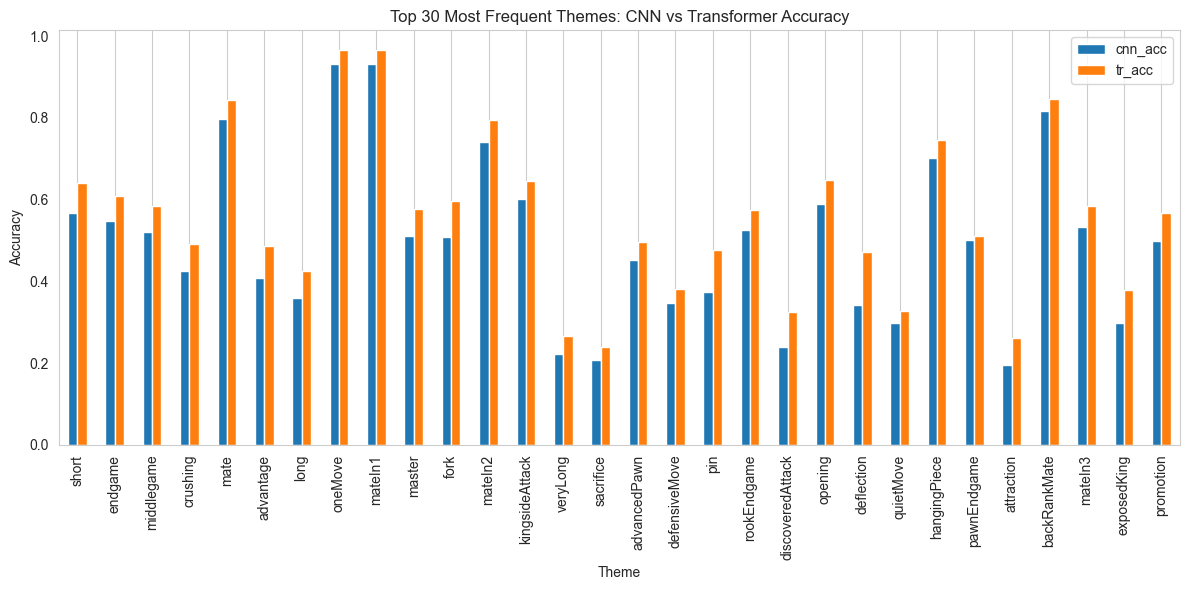

<Figure size 1200x600 with 0 Axes>

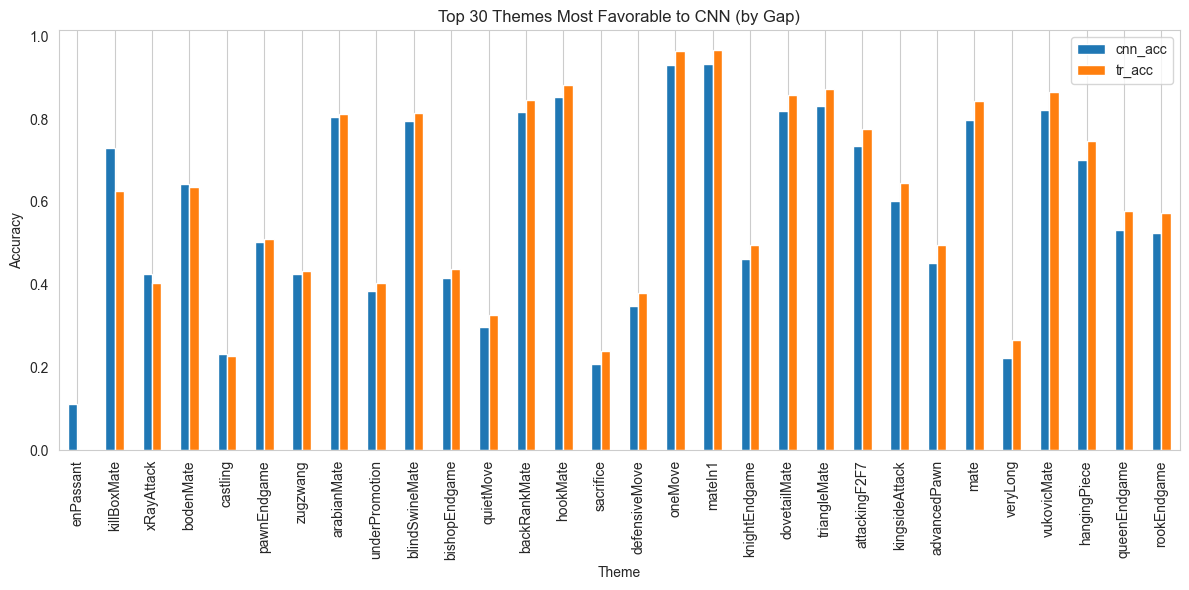

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Select only necessary columns BEFORE exploding (critical for memory efficiency)
subset_df = results_df_raw[['PuzzleId', 'Themes', 'cnn_puzzle_complete', 'transformer_puzzle_complete']].copy()

# 2) Explode Themes
exploded = (
    subset_df
    .dropna(subset=["Themes"])
    .assign(Theme=subset_df["Themes"].astype(str).str.split())
    .explode("Theme")
)

# Remove empty tokens
exploded = exploded[exploded["Theme"].notna() & exploded["Theme"].ne("")]

# 3) Accuracy + support per theme
theme_stats = (
    exploded.groupby("Theme")
    .agg(
        n=("Theme", "size"),
        cnn_acc=("cnn_puzzle_complete", "mean"),
        tr_acc=("transformer_puzzle_complete", "mean"),
    )
)

theme_stats["Gap"] = theme_stats["tr_acc"] - theme_stats["cnn_acc"]

# Filter for themes with at least 500 puzzles (statistical significance)
theme_stats = theme_stats[theme_stats['n'] >= 500]

print(f"--- Themes with ≥500 puzzles: {len(theme_stats)} themes ---")
display(theme_stats.sort_values("Gap").head(20))  # Top 20 CNN-favorable themes


# 3) Plotting (all themes is unreadable). Plot Top-K by support or by gap.
TOP_K = 30

# Example A: most frequent themes (best for stability)
top_by_support = theme_stats.sort_values("n", ascending=False).head(TOP_K)

plt.figure(figsize=(12, 6))
top_by_support[["cnn_acc","tr_acc"]].plot(kind="bar", figsize=(12,6))
plt.title(f"Top {TOP_K} Most Frequent Themes: CNN vs Transformer Accuracy")
plt.ylabel("Accuracy")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# Example B: where CNN is strongest (but avoid tiny-n noise: still show n)
top_cnn = theme_stats.sort_values("Gap").head(TOP_K)

plt.figure(figsize=(12, 6))
top_cnn[["cnn_acc","tr_acc"]].plot(kind="bar", figsize=(12,6))
plt.title(f"Top {TOP_K} Themes Most Favorable to CNN (by Gap)")
plt.ylabel("Accuracy")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


--- Themes where CNN Outperforms Transformer ---


,cnn_puzzle_complete,transformer_puzzle_complete,CNN_Advantage
Theme,,,
enPassant,0.112281,0.000376,0.111905
killBoxMate,0.730013,0.627091,0.102922
xRayAttack,0.425828,0.404650,0.021178
bodenMate,0.642115,0.636308,0.005807
castling,0.231548,0.229017,0.002531
pawnEndgame,0.502342,0.510454,-0.008112
zugzwang,0.425694,0.434162,-0.008468
arabianMate,0.804288,0.813564,-0.009276
underPromotion,0.384840,0.405248,-0.020408


C:\Users\yothman\AppData\Local\Temp\ipykernel_34404\2582461793.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cnn_favorites['CNN_Advantage'], y=cnn_favorites.index, palette='Reds_r')


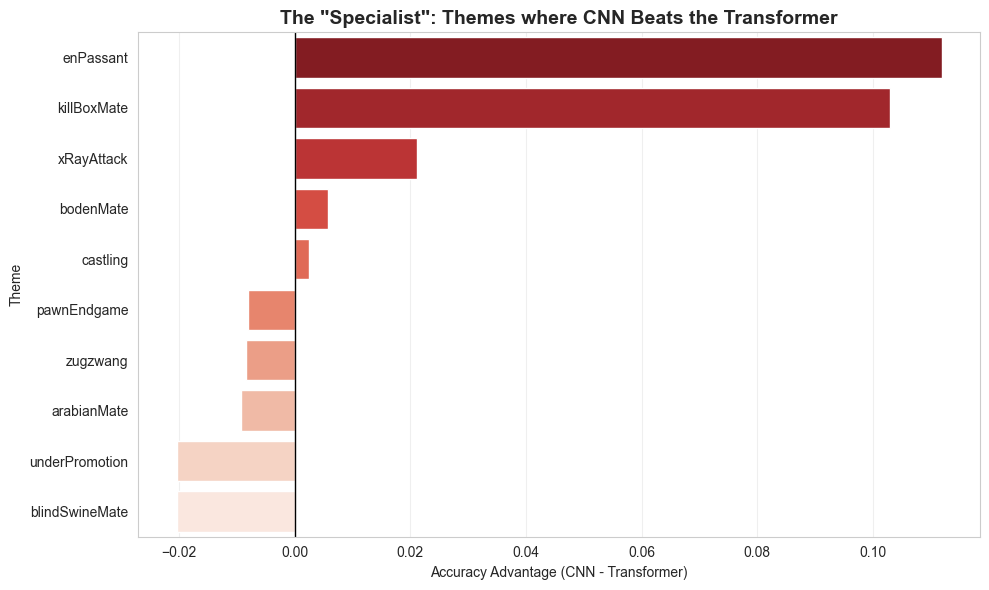


CNN 'Revenge' Count: 362,347 puzzles
Avg Rating of Revenge Puzzles: 1606
Global Avg Rating: 1484


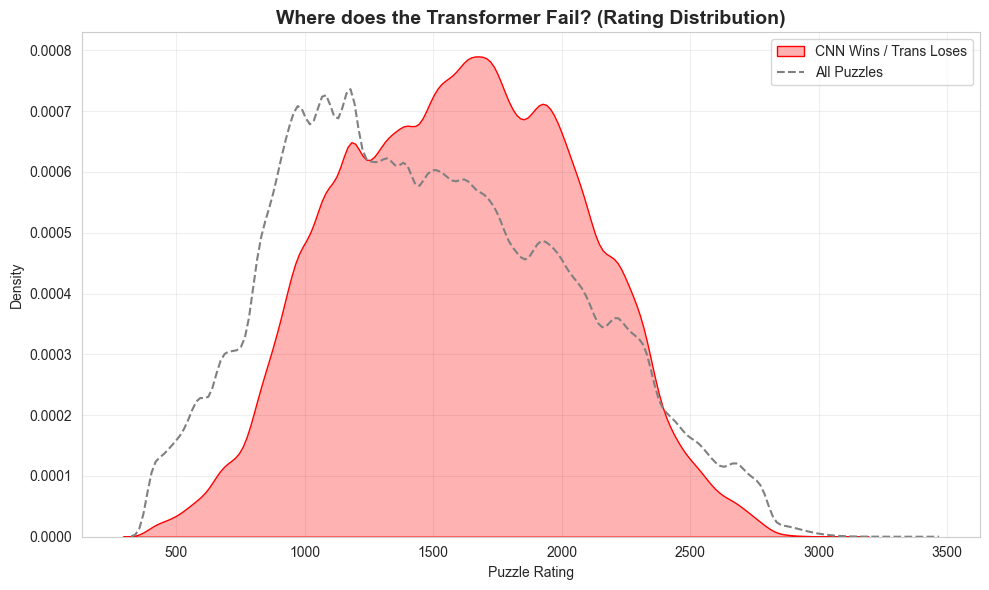

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# --- 1. THEME ANALYSIS (The "Specialist" Argument) ---
# Memory-efficient: Select only necessary columns BEFORE exploding
subset_df = results_df_raw[['PuzzleId', 'Themes', 'Rating', 'cnn_puzzle_complete', 'transformer_puzzle_complete']].copy()

# Explode themes to analyze them individually
exploded_themes = subset_df.dropna(subset=['Themes']).assign(Theme=subset_df['Themes'].str.split(' ')).explode('Theme')

# Filter for themes with at least 500 puzzles (to ensure statistical significance)
theme_counts = exploded_themes['Theme'].value_counts()
valid_themes = theme_counts[theme_counts > 500].index
theme_data = exploded_themes[exploded_themes['Theme'].isin(valid_themes)]

# Calculate accuracy per theme
theme_perf = theme_data.groupby('Theme')[['cnn_puzzle_complete', 'transformer_puzzle_complete']].mean()

# Calculate "CNN Advantage" (Positive means CNN wins)
theme_perf['CNN_Advantage'] = theme_perf['cnn_puzzle_complete'] - theme_perf['transformer_puzzle_complete']

# Get the top 10 themes where CNN is strongest
cnn_favorites = theme_perf.sort_values('CNN_Advantage', ascending=False).head(10)

print("--- Themes where CNN Outperforms Transformer ---")
display(cnn_favorites)

# Visualization 1: CNN's Strongest Themes
plt.figure(figsize=(10, 6))
sns.barplot(x=cnn_favorites['CNN_Advantage'], y=cnn_favorites.index, palette='Reds_r')
plt.axvline(0, color='black', linewidth=1)
plt.title('The "Specialist": Themes where CNN Beats the Transformer', fontsize=14, fontweight='bold')
plt.xlabel('Accuracy Advantage (CNN - Transformer)')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# --- 2. RATING ANALYSIS (The "Complexity" Argument) ---
# Use full dataframe for rating analysis (already done in previous cell)
# Skipping to avoid duplication

# --- 3. REVENGE ANALYSIS (The "Blind Spot" Argument) ---
# Isolate puzzles where CNN is RIGHT and Transformer is WRONG
revenge_df = results_df_raw[(results_df_raw['cnn_puzzle_complete'] == 1) & 
                             (results_df_raw['transformer_puzzle_complete'] == 0)]

print(f"\nCNN 'Revenge' Count: {len(revenge_df):,} puzzles")
print(f"Avg Rating of Revenge Puzzles: {revenge_df['Rating'].mean():.0f}")
print(f"Global Avg Rating: {results_df_raw['Rating'].mean():.0f}")

# Visualization 3: Distribution of Ratings
plt.figure(figsize=(10, 6))
sns.kdeplot(revenge_df['Rating'], fill=True, color='red', label='CNN Wins / Trans Loses', alpha=0.3)
sns.kdeplot(results_df_raw['Rating'], linestyle='--', color='gray', label='All Puzzles')
plt.title('Where does the Transformer Fail? (Rating Distribution)', fontsize=14, fontweight='bold')
plt.xlabel('Puzzle Rating')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

,n,cnn_acc,tr_acc,gap
puzzle_len_bin,,,,
1-2,797457,0.931940,0.965608,0.033668
3-4,2871557,0.568020,0.641322,0.073302
5-6,1466634,0.360844,0.425048,0.064204
7-10,419468,0.231827,0.279199,0.047372
11+,44970,0.139626,0.161174,0.021548


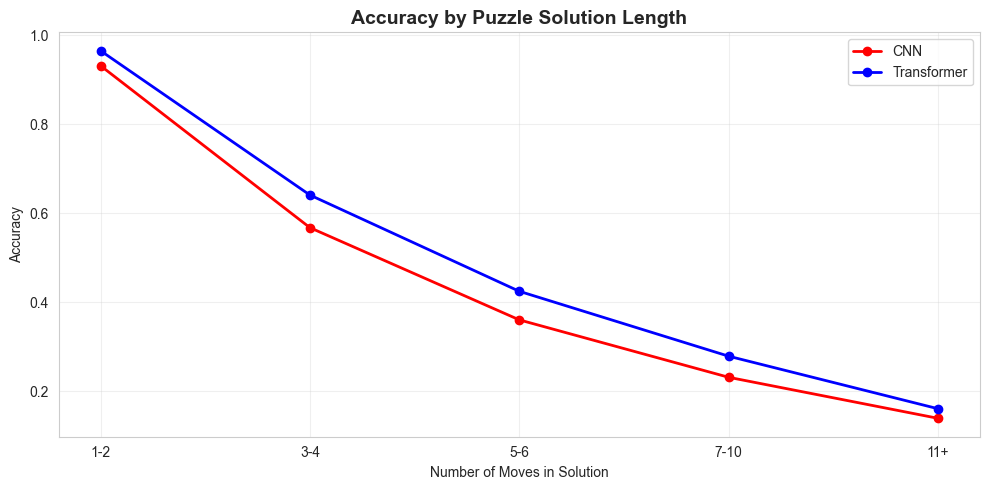

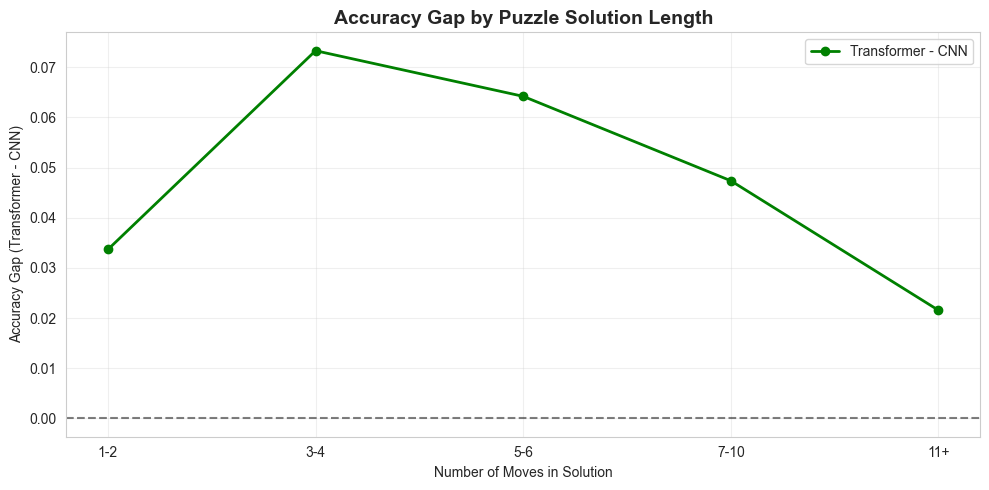

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Build/ensure puzzle solution length ---
# Uses "solution_len" if you already made it; otherwise compute from Moves
if "solution_len" not in results_df_raw.columns:
    results_df_raw["solution_len"] = results_df_raw["Moves"].fillna("").astype(str).str.split().str.len()

# Define bins (tweak as you like)
bins = [0, 2, 4, 6, 10, 1000]
labels = ["1-2", "3-4", "5-6", "7-10", "11+"]

results_df_raw["puzzle_len_bin"] = pd.cut(results_df_raw["solution_len"], bins=bins, labels=labels)

# Aggregate
puz = (results_df_raw.groupby("puzzle_len_bin", observed=True)
       .agg(n=("solution_len", "size"),
            cnn_acc=("cnn_puzzle_complete", "mean"),
            tr_acc=("transformer_puzzle_complete", "mean"))
       .assign(gap=lambda t: t["tr_acc"] - t["cnn_acc"]))

display(puz)

# Plot accuracies
plt.figure(figsize=(10,5))
plt.plot(puz.index.astype(str), puz["cnn_acc"], marker="o", label="CNN", linewidth=2, color='red')
plt.plot(puz.index.astype(str), puz["tr_acc"], marker="o", label="Transformer", linewidth=2, color='blue')
plt.title("Accuracy by Puzzle Solution Length", fontsize=14, fontweight='bold')
plt.xlabel("Number of Moves in Solution")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Plot gap (TR - CNN)
plt.figure(figsize=(10,5))
plt.plot(puz.index.astype(str), puz["gap"], marker="o", label="Transformer - CNN", linewidth=2, color='green')
plt.axhline(0, linestyle="--", color='black', alpha=0.5)
plt.title("Accuracy Gap by Puzzle Solution Length", fontsize=14, fontweight='bold')
plt.xlabel("Number of Moves in Solution")
plt.ylabel("Accuracy Gap (Transformer - CNN)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


TR-only: 714691
CNN-only: 362347


,Theme,KL_Contribution
21,deflection,0.011433
8,mateIn1,0.011282
7,oneMove,0.011210
10,fork,0.009496
17,pin,0.007164
0,short,0.006466
4,mate,0.005445
19,discoveredAttack,0.004337
5,advantage,0.004186
1,endgame,0.001686


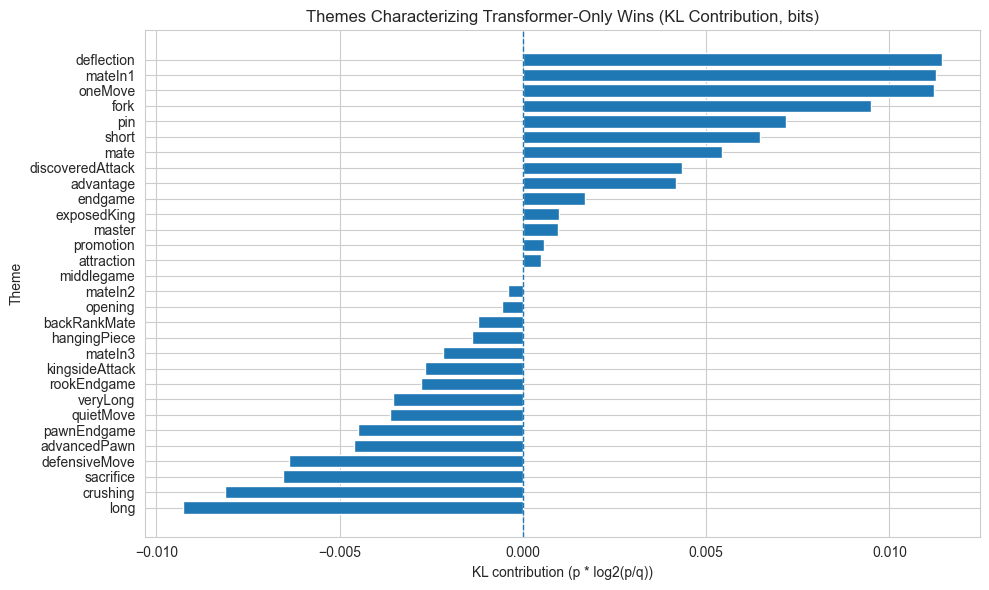

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Disagreement sets
tr_only = results_df_raw[(results_df_raw["transformer_puzzle_complete"] == 1) &
                     (results_df_raw["cnn_puzzle_complete"] == 0)].copy()

cnn_only = results_df_raw[(results_df_raw["cnn_puzzle_complete"] == 1) &
                      (results_df_raw["transformer_puzzle_complete"] == 0)].copy()
print("TR-only:", len(tr_only))
print("CNN-only:", len(cnn_only))

def theme_counts(df):
    s = df["Themes"].fillna("").astype(str).str.split()
    exploded = s.explode()
    exploded = exploded[exploded.ne("")]  # remove empties
    return exploded.value_counts()

# Vocabulary: top K themes overall (or use all themes)
K = 30
all_top = theme_counts(results_df_raw).head(K).index

dist_tr  = theme_counts(tr_only).reindex(all_top).fillna(0)
dist_cnn = theme_counts(cnn_only).reindex(all_top).fillna(0)

# Proper epsilon smoothing
eps = 1e-9
p = (dist_tr  + eps) / (dist_tr  + eps).sum()
q = (dist_cnn + eps) / (dist_cnn + eps).sum()

# KL contributions (in bits)
kl_contrib = p * np.log2(p / q)

kl_df = (pd.DataFrame({"Theme": all_top, "KL_Contribution": kl_contrib.values})
           .sort_values("KL_Contribution", ascending=False))

display(kl_df.head(30))

# Plot (horizontal bars)
plt.figure(figsize=(10, 6))
plt.barh(kl_df["Theme"][::-1], kl_df["KL_Contribution"][::-1])
plt.axvline(0, linestyle="--", linewidth=1)
plt.title("Themes Characterizing Transformer-Only Wins (KL Contribution, bits)")
plt.xlabel("KL contribution (p * log2(p/q))")
plt.ylabel("Theme")
plt.tight_layout()
plt.show()


Analyzing average move distances for ALL moves in each puzzle...
Transformer-only wins (full puzzle): 714,691
CNN-only wins (full puzzle): 362,347

Transformer-only wins:
  Avg move distance: 3.18
  Median move distance: 3.00
  Std: 1.47

CNN-only wins:
  Avg move distance: 3.05
  Median move distance: 3.00
  Std: 1.43


C:\Users\yothman\AppData\Local\Temp\ipykernel_34404\4167778984.py:67: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot([tr_only_avg_distances, cnn_only_avg_distances],


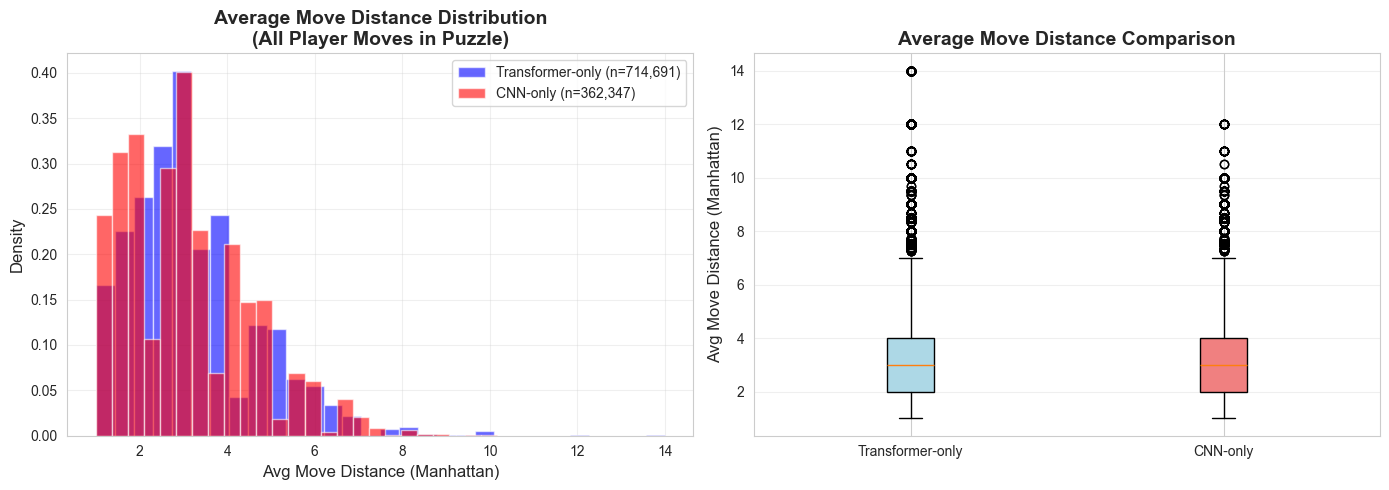


--- Long Puzzles (≥3 player moves) ---
Total long puzzles: 1,931,072
Transformer-only wins: 263,476
CNN-only wins: 148,472

Transformer-only (long puzzles):
  Avg move distance: 2.96
  Median: 2.75

CNN-only (long puzzles):
  Avg move distance: 2.83
  Median: 2.67


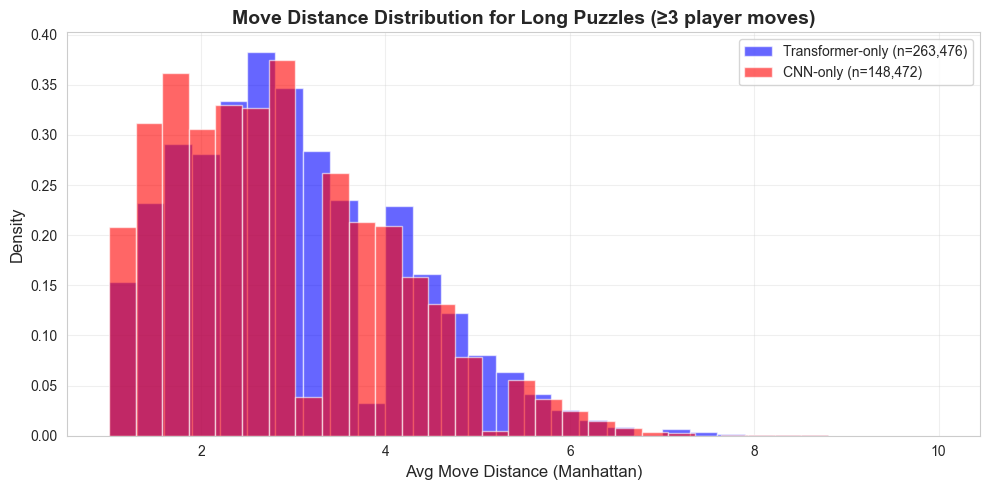

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def move_distance(uci_move):
    """Manhattan distance from source to destination square"""
    from_sq = uci_move[:2]
    to_sq = uci_move[2:4]
    
    from_file, from_rank = ord(from_sq[0]) - ord('a'), int(from_sq[1])
    to_file, to_rank = ord(to_sq[0]) - ord('a'), int(to_sq[1])
    
    return abs(to_file - from_file) + abs(to_rank - from_rank)

def get_avg_move_distance(moves_str):
    """Calculate average move distance for ALL expected moves in a puzzle.
    Moves format: opponent_move expected_move1 opponent_move2 expected_move2 ...
    Player moves are at odd indices (1, 3, 5, ...)"""
    try:
        moves = moves_str.split()
        # Player's moves are at odd indices (1, 3, 5, ...)
        player_moves = [moves[i] for i in range(1, len(moves), 2)]
        if not player_moves:
            return None
        distances = [move_distance(m[:4]) for m in player_moves]
        return np.mean(distances)
    except:
        return None

# Define disagreement sets using puzzle_complete metric
tr_only = results_df_raw[(results_df_raw['transformer_puzzle_complete'] == 1) & 
                          (results_df_raw['cnn_puzzle_complete'] == 0)]
cnn_only = results_df_raw[(results_df_raw['cnn_puzzle_complete'] == 1) & 
                           (results_df_raw['transformer_puzzle_complete'] == 0)]

print("Analyzing average move distances for ALL moves in each puzzle...")
print(f"Transformer-only wins (full puzzle): {len(tr_only):,}")
print(f"CNN-only wins (full puzzle): {len(cnn_only):,}")

# Calculate average distances across all player moves
tr_only_avg_distances = tr_only['Moves'].apply(get_avg_move_distance).dropna().tolist()
cnn_only_avg_distances = cnn_only['Moves'].apply(get_avg_move_distance).dropna().tolist()

print(f"\nTransformer-only wins:")
print(f"  Avg move distance: {np.mean(tr_only_avg_distances):.2f}")
print(f"  Median move distance: {np.median(tr_only_avg_distances):.2f}")
print(f"  Std: {np.std(tr_only_avg_distances):.2f}")

print(f"\nCNN-only wins:")
print(f"  Avg move distance: {np.mean(cnn_only_avg_distances):.2f}")
print(f"  Median move distance: {np.median(cnn_only_avg_distances):.2f}")
print(f"  Std: {np.std(cnn_only_avg_distances):.2f}")

# Visualize distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(tr_only_avg_distances, bins=30, alpha=0.6, label=f'Transformer-only (n={len(tr_only_avg_distances):,})', color='blue', density=True)
axes[0].hist(cnn_only_avg_distances, bins=30, alpha=0.6, label=f'CNN-only (n={len(cnn_only_avg_distances):,})', color='red', density=True)
axes[0].set_xlabel('Avg Move Distance (Manhattan)', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].set_title('Average Move Distance Distribution\n(All Player Moves in Puzzle)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
bp = axes[1].boxplot([tr_only_avg_distances, cnn_only_avg_distances], 
                     labels=['Transformer-only', 'CNN-only'],
                     patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightcoral')
axes[1].set_ylabel('Avg Move Distance (Manhattan)', fontsize=12)
axes[1].set_title('Average Move Distance Comparison', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Stratify by puzzle length to see if the pattern holds
results_df_raw['avg_move_dist'] = results_df_raw['Moves'].apply(get_avg_move_distance)
results_df_raw['num_player_moves'] = results_df_raw['Moves'].apply(lambda x: len(x.split()) // 2)

# For long puzzles specifically, compare distances
long_puzzles = results_df_raw[results_df_raw['num_player_moves'] >= 3]
long_tr_only = long_puzzles[(long_puzzles['transformer_puzzle_complete'] == 1) & 
                             (long_puzzles['cnn_puzzle_complete'] == 0)]
long_cnn_only = long_puzzles[(long_puzzles['cnn_puzzle_complete'] == 1) & 
                              (long_puzzles['transformer_puzzle_complete'] == 0)]

print(f"\n--- Long Puzzles (≥3 player moves) ---")
print(f"Total long puzzles: {len(long_puzzles):,}")
print(f"Transformer-only wins: {len(long_tr_only):,}")
print(f"CNN-only wins: {len(long_cnn_only):,}")

print(f"\nTransformer-only (long puzzles):")
print(f"  Avg move distance: {long_tr_only['avg_move_dist'].mean():.2f}")
print(f"  Median: {long_tr_only['avg_move_dist'].median():.2f}")

print(f"\nCNN-only (long puzzles):")
print(f"  Avg move distance: {long_cnn_only['avg_move_dist'].mean():.2f}")
print(f"  Median: {long_cnn_only['avg_move_dist'].median():.2f}")

# Visualize long puzzles comparison
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(long_tr_only['avg_move_dist'].dropna(), bins=30, alpha=0.6, 
        label=f'Transformer-only (n={len(long_tr_only):,})', color='blue', density=True)
ax.hist(long_cnn_only['avg_move_dist'].dropna(), bins=30, alpha=0.6, 
        label=f'CNN-only (n={len(long_cnn_only):,})', color='red', density=True)
ax.set_xlabel('Avg Move Distance (Manhattan)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Move Distance Distribution for Long Puzzles (≥3 player moves)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

1. FIRST MOVE DISTANCE ANALYSIS

Transformer-only wins - First move distance:
  Mean: 3.28, Median: 3.00

CNN-only wins - First move distance:
  Mean: 3.10, Median: 3.00


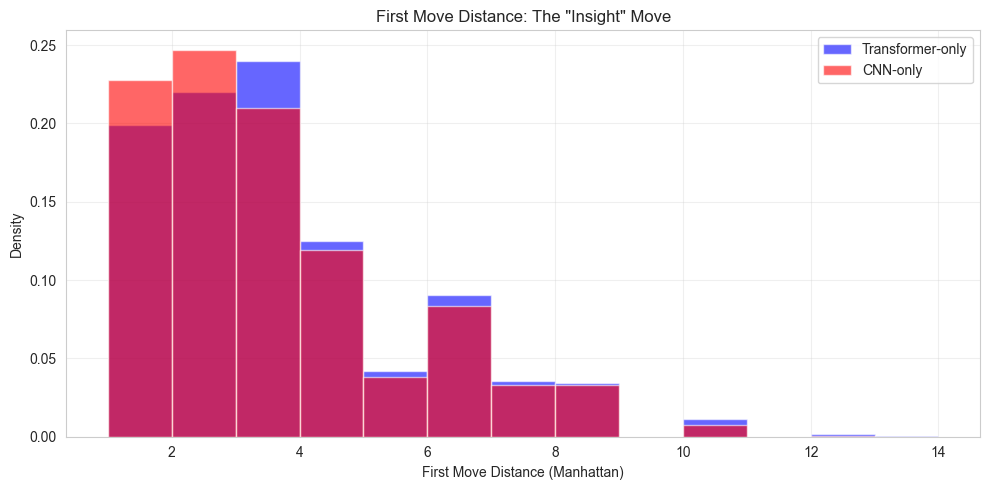


2. PIECE TYPE ANALYSIS

First Move Piece Distribution:
   Transformer-only  CNN-only  Δ (TR - CNN)
B            0.1251    0.1257       -0.0006
K            0.0387    0.0540       -0.0153
N            0.1730    0.1479        0.0250
P            0.1010    0.1467       -0.0457
Q            0.2798    0.2711        0.0087
R            0.2823    0.2546        0.0278

Local pieces (P, K):
  Transformer-only: 13.97%
  CNN-only: 20.07%

Knight (N):
  Transformer-only: 17.30%
  CNN-only: 14.79%

Slider pieces (B, R, Q):
  Transformer-only: 68.73%
  CNN-only: 65.14%


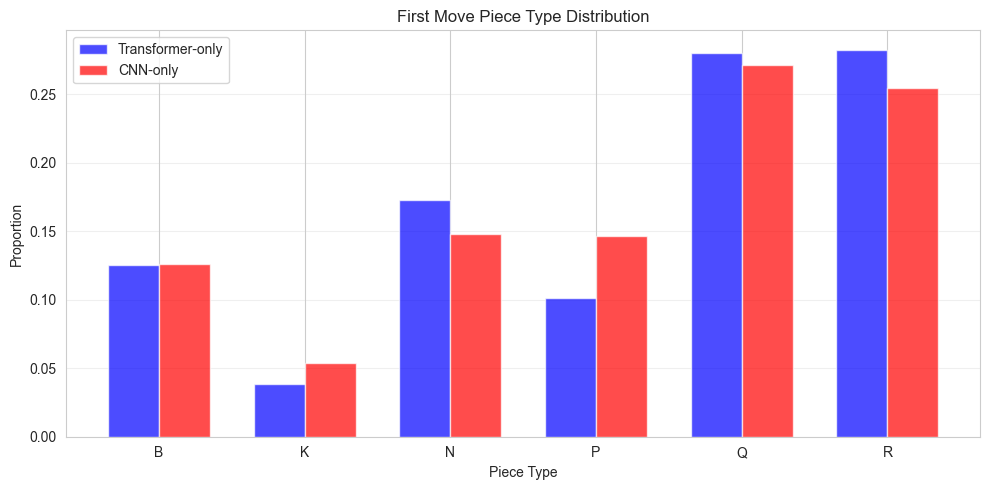


3. SPATIAL SPREAD ANALYSIS
Analyzing spatial spread on 50000 samples per group...

Bounding Box Area (squares involved):
  Transformer-only: Mean=32.62, Median=30.00
  CNN-only: Mean=32.49, Median=30.00

Avg Pairwise Distance (spread of action):
  Transformer-only: Mean=4.13, Median=4.11
  CNN-only: Mean=4.07, Median=4.07


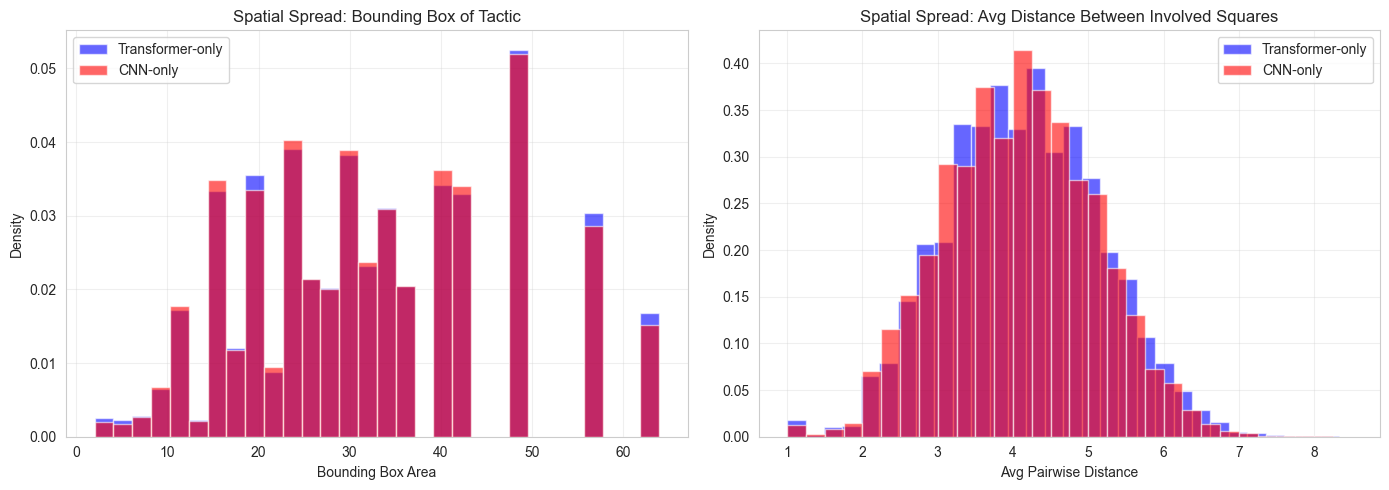


SUMMARY
                 Metric  Transformer-only  CNN-only  Δ (TR - CNN)
    First Move Distance             3.277     3.101         0.176
   Local Pieces (P,K) %            13.971    20.069        -6.097
           Knight (N) %            17.298    14.794         2.504
Slider Pieces (B,R,Q) %            68.730    65.138         3.593
      Bounding Box Area            32.625    32.486         0.139
  Avg Pairwise Distance             4.126     4.073         0.052


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import chess

# ============================================================
# 1. FIRST MOVE DISTANCE ANALYSIS
# ============================================================

def first_move_distance(moves_str):
    """Distance of the first player move (the 'insight' move)"""
    try:
        moves = moves_str.split()
        if len(moves) >= 2:
            return move_distance(moves[1][:4])
        return None
    except:
        return None

print("=" * 60)
print("1. FIRST MOVE DISTANCE ANALYSIS")
print("=" * 60)

tr_only_first = tr_only['Moves'].apply(first_move_distance).dropna()
cnn_only_first = cnn_only['Moves'].apply(first_move_distance).dropna()

print(f"\nTransformer-only wins - First move distance:")
print(f"  Mean: {tr_only_first.mean():.2f}, Median: {tr_only_first.median():.2f}")

print(f"\nCNN-only wins - First move distance:")
print(f"  Mean: {cnn_only_first.mean():.2f}, Median: {cnn_only_first.median():.2f}")

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(tr_only_first, bins=range(1, 15), alpha=0.6, label='Transformer-only', color='blue', density=True)
ax.hist(cnn_only_first, bins=range(1, 15), alpha=0.6, label='CNN-only', color='red', density=True)
ax.set_xlabel('First Move Distance (Manhattan)')
ax.set_ylabel('Density')
ax.set_title('First Move Distance: The "Insight" Move')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# 2. PIECE TYPE ANALYSIS
# ============================================================

def get_moving_piece(fen, uci_move):
    """Get the piece type that makes a move"""
    try:
        board = chess.Board(fen)
        from_square = chess.parse_square(uci_move[:2])
        piece = board.piece_at(from_square)
        if piece:
            return piece.symbol().upper()  # P, N, B, R, Q, K
        return None
    except:
        return None

def get_first_move_piece(row):
    """Get the piece type of the first player move"""
    try:
        moves = row['Moves'].split()
        if len(moves) >= 2:
            # Apply opponent's move first to get correct position
            board = chess.Board(row['FEN'])
            board.push_uci(moves[0])
            # Now get the piece that makes the first player move
            from_square = chess.parse_square(moves[1][:2])
            piece = board.piece_at(from_square)
            if piece:
                return piece.symbol().upper()
        return None
    except:
        return None

print("\n" + "=" * 60)
print("2. PIECE TYPE ANALYSIS")
print("=" * 60)

tr_only_pieces = tr_only.apply(get_first_move_piece, axis=1).dropna()
cnn_only_pieces = cnn_only.apply(get_first_move_piece, axis=1).dropna()

# Count distributions
tr_piece_counts = tr_only_pieces.value_counts(normalize=True).sort_index()
cnn_piece_counts = cnn_only_pieces.value_counts(normalize=True).sort_index()

piece_df = pd.DataFrame({
    'Transformer-only': tr_piece_counts,
    'CNN-only': cnn_piece_counts
}).fillna(0)
piece_df['Δ (TR - CNN)'] = piece_df['Transformer-only'] - piece_df['CNN-only']

print("\nFirst Move Piece Distribution:")
print(piece_df.round(4))

# Categorize: local vs knight vs long-range
local_pieces = ['P', 'K']  # Pawns, Kings - truly adjacent movement
knight_pieces = ['N']  # Knights - unique L-shaped movement
slider_pieces = ['B', 'R', 'Q']  # Bishops, Rooks, Queens - long-range

tr_local = tr_only_pieces[tr_only_pieces.isin(local_pieces)].count() / len(tr_only_pieces)
tr_knight = tr_only_pieces[tr_only_pieces.isin(knight_pieces)].count() / len(tr_only_pieces)
tr_slider = tr_only_pieces[tr_only_pieces.isin(slider_pieces)].count() / len(tr_only_pieces)
cnn_local = cnn_only_pieces[cnn_only_pieces.isin(local_pieces)].count() / len(cnn_only_pieces)
cnn_knight = cnn_only_pieces[cnn_only_pieces.isin(knight_pieces)].count() / len(cnn_only_pieces)
cnn_slider = cnn_only_pieces[cnn_only_pieces.isin(slider_pieces)].count() / len(cnn_only_pieces)

print(f"\nLocal pieces (P, K):")
print(f"  Transformer-only: {tr_local:.2%}")
print(f"  CNN-only: {cnn_local:.2%}")

print(f"\nKnight (N):")
print(f"  Transformer-only: {tr_knight:.2%}")
print(f"  CNN-only: {cnn_knight:.2%}")

print(f"\nSlider pieces (B, R, Q):")
print(f"  Transformer-only: {tr_slider:.2%}")
print(f"  CNN-only: {cnn_slider:.2%}")

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(piece_df))
width = 0.35
ax.bar(x - width/2, piece_df['Transformer-only'], width, label='Transformer-only', color='blue', alpha=0.7)
ax.bar(x + width/2, piece_df['CNN-only'], width, label='CNN-only', color='red', alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(piece_df.index)
ax.set_ylabel('Proportion')
ax.set_xlabel('Piece Type')
ax.set_title('First Move Piece Type Distribution')
ax.legend()
ax.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# ============================================================
# 3. SPATIAL SPREAD OF THE TACTIC
# ============================================================

def get_spatial_spread(row):
    """
    Calculate how spread out the relevant pieces are.
    We look at all squares involved in the solution moves.
    Returns: bounding box area, and average pairwise distance
    """
    try:
        board = chess.Board(row['FEN'])
        moves = row['Moves'].split()
        
        involved_squares = set()
        
        # Collect all squares involved in the solution
        for i, move in enumerate(moves):
            uci = move[:4]
            from_sq = chess.parse_square(uci[:2])
            to_sq = chess.parse_square(uci[2:4])
            involved_squares.add(from_sq)
            involved_squares.add(to_sq)
            
            # Also add captured piece square if any
            if board.is_capture(chess.Move.from_uci(move[:4])):
                involved_squares.add(to_sq)
            
            # Push the move to update board
            try:
                board.push_uci(move[:4])
            except:
                break
        
        if len(involved_squares) < 2:
            return None, None
        
        # Convert to coordinates
        coords = [(sq % 8, sq // 8) for sq in involved_squares]
        
        # Bounding box
        files = [c[0] for c in coords]
        ranks = [c[1] for c in coords]
        bbox_area = (max(files) - min(files) + 1) * (max(ranks) - min(ranks) + 1)
        
        # Average pairwise Manhattan distance
        total_dist = 0
        count = 0
        for i, c1 in enumerate(coords):
            for c2 in coords[i+1:]:
                total_dist += abs(c1[0] - c2[0]) + abs(c1[1] - c2[1])
                count += 1
        avg_pairwise = total_dist / count if count > 0 else 0
        
        return bbox_area, avg_pairwise
    except:
        return None, None

print("\n" + "=" * 60)
print("3. SPATIAL SPREAD ANALYSIS")
print("=" * 60)

# Sample for speed (spatial analysis is slow)
sample_size = 50000
tr_sample = tr_only.sample(n=min(sample_size, len(tr_only)), random_state=42)
cnn_sample = cnn_only.sample(n=min(sample_size, len(cnn_only)), random_state=42)

print(f"Analyzing spatial spread on {sample_size} samples per group...")

tr_spread = tr_sample.apply(get_spatial_spread, axis=1)
cnn_spread = cnn_sample.apply(get_spatial_spread, axis=1)

tr_bbox = [x[0] for x in tr_spread if x[0] is not None]
tr_pairwise = [x[1] for x in tr_spread if x[1] is not None]
cnn_bbox = [x[0] for x in cnn_spread if x[0] is not None]
cnn_pairwise = [x[1] for x in cnn_spread if x[1] is not None]

print(f"\nBounding Box Area (squares involved):")
print(f"  Transformer-only: Mean={np.mean(tr_bbox):.2f}, Median={np.median(tr_bbox):.2f}")
print(f"  CNN-only: Mean={np.mean(cnn_bbox):.2f}, Median={np.median(cnn_bbox):.2f}")

print(f"\nAvg Pairwise Distance (spread of action):")
print(f"  Transformer-only: Mean={np.mean(tr_pairwise):.2f}, Median={np.median(tr_pairwise):.2f}")
print(f"  CNN-only: Mean={np.mean(cnn_pairwise):.2f}, Median={np.median(cnn_pairwise):.2f}")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(tr_bbox, bins=30, alpha=0.6, label='Transformer-only', color='blue', density=True)
axes[0].hist(cnn_bbox, bins=30, alpha=0.6, label='CNN-only', color='red', density=True)
axes[0].set_xlabel('Bounding Box Area')
axes[0].set_ylabel('Density')
axes[0].set_title('Spatial Spread: Bounding Box of Tactic')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].hist(tr_pairwise, bins=30, alpha=0.6, label='Transformer-only', color='blue', density=True)
axes[1].hist(cnn_pairwise, bins=30, alpha=0.6, label='CNN-only', color='red', density=True)
axes[1].set_xlabel('Avg Pairwise Distance')
axes[1].set_ylabel('Density')
axes[1].set_title('Spatial Spread: Avg Distance Between Involved Squares')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================
# SUMMARY TABLE
# ============================================================

print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)

summary = pd.DataFrame({
    'Metric': ['First Move Distance', 'Local Pieces (P,K) %', 'Knight (N) %', 'Slider Pieces (B,R,Q) %', 
               'Bounding Box Area', 'Avg Pairwise Distance'],
    'Transformer-only': [tr_only_first.mean(), tr_local*100, tr_knight*100, tr_slider*100, 
                         np.mean(tr_bbox), np.mean(tr_pairwise)],
    'CNN-only': [cnn_only_first.mean(), cnn_local*100, cnn_knight*100, cnn_slider*100,
                 np.mean(cnn_bbox), np.mean(cnn_pairwise)]
})
summary['Δ (TR - CNN)'] = summary['Transformer-only'] - summary['CNN-only']
print(summary.round(3).to_string(index=False))

CNN excels at truly adjacent-square tactics (pawn pushes, king walks)
Transformer excels at piece coordination, including knight geometry

Analyzing failure points...
Transformer failed puzzles: 2,240,708
CNN failed puzzles: 2,593,052

1. FAILURE BY MOVE INDEX

Failure distribution by move index:
             Transformer     CNN  Δ (CNN - TR)
failure_idx                                   
0                 0.7270  0.7386        0.0117
1                 0.2091  0.2037       -0.0053
2                 0.0518  0.0471       -0.0047
3                 0.0095  0.0082       -0.0013
4                 0.0020  0.0017       -0.0003
5                 0.0005  0.0004       -0.0001


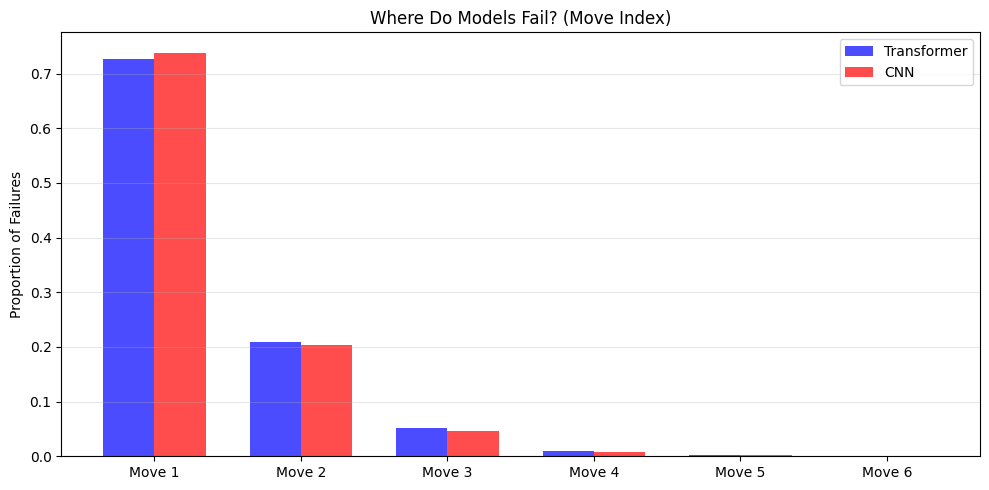


2. FAILURE BY PIECE TYPE

Failure distribution by piece type:
               Transformer     CNN  Δ (CNN - TR)
failure_piece                                   
B                   0.1383  0.1377       -0.0005
K                   0.0690  0.0619       -0.0071
N                   0.1441  0.1530        0.0089
P                   0.1488  0.1316       -0.0173
Q                   0.2387  0.2443        0.0056
R                   0.2611  0.2715        0.0103

3. PIECE TYPE BY MOVE DEPTH

Piece distribution: Early vs Late failures
               TR_Move1  TR_Move3+  CNN_Move1  CNN_Move3+
failure_piece                                            
B                0.1497     0.0880     0.1468      0.0930
K                0.0398     0.2129     0.0357      0.2046
N                0.1609     0.0763     0.1694      0.0808
P                0.1381     0.1890     0.1216      0.1723
Q                0.2398     0.2275     0.2452      0.2290
R                0.2717     0.2064     0.2812      0.2202

4. FAIL

In [3]:
import chess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# FAILURE POINT ANALYSIS
# ============================================================

def get_failure_move_info(row, model='transformer'):
    """
    Find the FIRST move the model got wrong and extract its characteristics.
    Returns: (failure_move_index, piece_type, move_distance, move_uci)
    """
    try:
        moves = row['Moves'].split()
        player_moves = [moves[i] for i in range(1, len(moves), 2)]  # Expected moves
        
        if model == 'transformer':
            correct_count = row['transformer_moves_correct']
            model_moves = row.get('transformer_moves', '').split() if 'transformer_moves' in row else None
        else:
            correct_count = row['cnn_moves_correct']
            model_moves = row.get('cnn_moves', '').split() if 'cnn_moves' in row else None
        
        total_player_moves = len(player_moves)
        
        # If solved completely, no failure
        if correct_count >= total_player_moves:
            return None, None, None, None, None
        
        # The failure happened at move index = correct_count
        failure_idx = int(correct_count)
        
        if failure_idx >= len(player_moves):
            return None, None, None, None, None
            
        # Get the move that should have been played
        expected_move = player_moves[failure_idx]
        
        # Reconstruct board state at failure point
        board = chess.Board(row['FEN'])
        
        # Play all moves up to the failure point
        for i, move in enumerate(moves):
            if i >= failure_idx * 2 + 1:  # Stop before the failure move
                break
            try:
                board.push_uci(move[:4] if len(move) == 4 else move[:5])
            except:
                return None, None, None, None, None
        
        # Extract info about the expected (failed) move
        from_sq = chess.parse_square(expected_move[:2])
        to_sq = chess.parse_square(expected_move[2:4])
        
        piece = board.piece_at(from_sq)
        piece_type = piece.symbol().upper() if piece else None
        
        # Manhattan distance
        from_file, from_rank = from_sq % 8, from_sq // 8
        to_file, to_rank = to_sq % 8, to_sq // 8
        dist = abs(to_file - from_file) + abs(to_rank - from_rank)
        
        return failure_idx, piece_type, dist, expected_move, total_player_moves
        
    except Exception as e:
        return None, None, None, None, None

# ============================================================
# Apply to failed puzzles only
# ============================================================

print("Analyzing failure points...")

# Transformer failures
tr_failed = results_df_raw[results_df_raw['transformer_puzzle_complete'] == 0].copy()
print(f"Transformer failed puzzles: {len(tr_failed):,}")

tr_failure_info = tr_failed.apply(lambda row: get_failure_move_info(row, 'transformer'), axis=1)
tr_failed[['failure_idx', 'failure_piece', 'failure_dist', 'failure_move', 'total_moves']] = pd.DataFrame(
    tr_failure_info.tolist(), index=tr_failed.index
)

# CNN failures
cnn_failed = results_df_raw[results_df_raw['cnn_puzzle_complete'] == 0].copy()
print(f"CNN failed puzzles: {len(cnn_failed):,}")

cnn_failure_info = cnn_failed.apply(lambda row: get_failure_move_info(row, 'cnn'), axis=1)
cnn_failed[['failure_idx', 'failure_piece', 'failure_dist', 'failure_move', 'total_moves']] = pd.DataFrame(
    cnn_failure_info.tolist(), index=cnn_failed.index
)

# ============================================================
# 1. WHERE do models fail? (Move index)
# ============================================================

print("\n" + "=" * 60)
print("1. FAILURE BY MOVE INDEX")
print("=" * 60)

tr_failure_dist = tr_failed['failure_idx'].value_counts(normalize=True).sort_index()
cnn_failure_dist = cnn_failed['failure_idx'].value_counts(normalize=True).sort_index()

failure_by_idx = pd.DataFrame({
    'Transformer': tr_failure_dist,
    'CNN': cnn_failure_dist
}).fillna(0).head(6)  # First 6 moves
failure_by_idx['Δ (CNN - TR)'] = failure_by_idx['CNN'] - failure_by_idx['Transformer']

print("\nFailure distribution by move index:")
print(failure_by_idx.round(4))

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(failure_by_idx))
width = 0.35
ax.bar(x - width/2, failure_by_idx['Transformer'], width, label='Transformer', color='blue', alpha=0.7)
ax.bar(x + width/2, failure_by_idx['CNN'], width, label='CNN', color='red', alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels([f'Move {i+1}' for i in failure_by_idx.index])
ax.set_ylabel('Proportion of Failures')
ax.set_title('Where Do Models Fail? (Move Index)')
ax.legend()
ax.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# ============================================================
# 2. WHAT piece causes failures?
# ============================================================

print("\n" + "=" * 60)
print("2. FAILURE BY PIECE TYPE")
print("=" * 60)

tr_piece_failures = tr_failed['failure_piece'].value_counts(normalize=True).sort_index()
cnn_piece_failures = cnn_failed['failure_piece'].value_counts(normalize=True).sort_index()

piece_failures = pd.DataFrame({
    'Transformer': tr_piece_failures,
    'CNN': cnn_piece_failures
}).fillna(0)
piece_failures['Δ (CNN - TR)'] = piece_failures['CNN'] - piece_failures['Transformer']

print("\nFailure distribution by piece type:")
print(piece_failures.round(4))

# ============================================================
# 3. INTERACTION: Move index × Piece type
# ============================================================

print("\n" + "=" * 60)
print("3. PIECE TYPE BY MOVE DEPTH")
print("=" * 60)

# For move 1 failures vs move 3+ failures, how does piece distribution differ?
tr_early = tr_failed[tr_failed['failure_idx'] == 0]['failure_piece'].value_counts(normalize=True)
tr_late = tr_failed[tr_failed['failure_idx'] >= 2]['failure_piece'].value_counts(normalize=True)

cnn_early = cnn_failed[cnn_failed['failure_idx'] == 0]['failure_piece'].value_counts(normalize=True)
cnn_late = cnn_failed[cnn_failed['failure_idx'] >= 2]['failure_piece'].value_counts(normalize=True)

depth_comparison = pd.DataFrame({
    'TR_Move1': tr_early,
    'TR_Move3+': tr_late,
    'CNN_Move1': cnn_early,
    'CNN_Move3+': cnn_late
}).fillna(0)

print("\nPiece distribution: Early vs Late failures")
print(depth_comparison.round(4))

# ============================================================
# 4. FAILURE DISTANCE BY MOVE DEPTH
# ============================================================

print("\n" + "=" * 60)
print("4. FAILURE MOVE DISTANCE BY DEPTH")
print("=" * 60)

for model, df in [('Transformer', tr_failed), ('CNN', cnn_failed)]:
    print(f"\n{model}:")
    for idx in [0, 1, 2]:
        subset = df[df['failure_idx'] == idx]['failure_dist'].dropna()
        if len(subset) > 100:
            print(f"  Move {idx+1}: mean={subset.mean():.2f}, median={subset.median():.2f}, n={len(subset):,}")


## Key Findings: Depth Analysis

### Key Finding 1: Move Distance DECREASES with Depth

| Depth | Transformer | CNN | Δ |
|-------|-------------|-----|---|
| Move 1 | 3.12 | 3.17 | -0.05 |
| Move 2 | 2.61 | 2.71 | -0.10 |
| Move 3 | 2.38 | 2.48 | -0.10 |

**Later moves are more local!** This directly supports the earlier hypothesis - long puzzles involve sequences of increasingly short-range moves.

---

### Key Finding 2: Piece Shifts Dramatically by Depth

| Piece | Move 1 Failures | Move 3+ Failures | Change |
|-------|-----------------|------------------|--------|
| King | ~4% | ~21% | +17% |
| Pawn | ~13% | ~18% | +5% |
| Rook | ~28% | ~21% | -7% |
| Knight | ~17% | ~8% | -9% |
| Bishop | ~15% | ~9% | -6% |

**Early failures are on tactical pieces (R, N, B). Late failures are on local pieces (K, P).**

---

### Key Finding 3: CNN Fails More on Longer Moves (at every depth)

At every depth, CNN's failed moves have **~0.05-0.10 longer distance** than Transformer's. This is consistent - the transformer is uniformly better at long-range regardless of move number.

---

## The Emerging Story

**Long puzzles are hard for Transformers because:**

| Move | Pattern | Implication |
|------|---------|-------------|
| Move 1 | Long-range tactic | Transformer advantage |
| Move 2 | Medium-range follow-up | Transformer still ahead |
| Move 3+ | Short-range king/pawn play | CNN catches up |

**The CNN's "local" advantage compounds over multiple moves.**